In [11]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
from torchsummary import summary

torch.__version__, np.__version__, pd.__version__

('2.0.1+cu117', '1.21.5', '1.2.4')

In [12]:
focue_CPU = False
#focue_CPU = True

def get_device():
    curr_dev = torch.device("cpu")
    if focue_CPU == True:
        curr_dev = torch.device("cpu")
    else:
        curr_dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    return curr_dev

curr_device = get_device()
print("current device : ", curr_device)
#currr_device = torch.device("cpu")

current device :  cuda:0


残差块， 此代码生成两种类型的网络： 一种是当use_1x1conv=False时，应用ReLU非线性函数之前，将输入添加到输出。 另一种是当use_1x1conv=True时，添加通过
卷积调整通道和分辨率。

In [13]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv = False, strides =1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels,num_channels,kernel_size=3, padding=1,stride=strides)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels,num_channels,kernel_size=3, padding=1,)
        self.bn2 = nn.BatchNorm2d(num_channels)

        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels,num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
    
    def forward(self, X):
        Y = self.conv1(X)
        Y = self.bn1(Y)
        Y = F.relu(Y)
        Y = self.conv2(Y)
        Y = self.bn2(Y)

        if self.conv3:
            X = self.conv3(X)
        Y += X
        
        Y = F.relu(Y)
        return Y
    

In [14]:
X = torch.rand(4,3,6,6)
X.shape

torch.Size([4, 3, 6, 6])

In [15]:
X

tensor([[[[1.1102e-01, 1.9602e-01, 3.3824e-01, 4.6822e-01, 7.5953e-01,
           4.2966e-01],
          [6.1699e-01, 3.8442e-01, 8.2376e-01, 9.7527e-01, 7.9329e-01,
           1.6688e-01],
          [8.3003e-02, 8.9905e-02, 6.1758e-02, 7.3511e-01, 7.6894e-01,
           2.7562e-01],
          [6.6435e-01, 7.6693e-01, 8.3369e-01, 3.9425e-02, 5.9584e-01,
           7.3265e-02],
          [9.7417e-01, 9.3291e-01, 7.6713e-01, 1.4630e-01, 2.8621e-01,
           5.4679e-01],
          [2.6889e-01, 2.1189e-01, 9.8961e-01, 8.9319e-01, 7.0698e-01,
           7.4531e-02]],

         [[4.2420e-01, 1.4729e-02, 9.6814e-01, 4.0013e-01, 9.9753e-01,
           5.1641e-01],
          [3.8240e-01, 2.4960e-01, 7.9339e-02, 7.9953e-01, 8.2488e-01,
           9.3580e-01],
          [3.3223e-01, 2.0574e-01, 5.7536e-01, 9.0159e-01, 5.9386e-01,
           7.2136e-01],
          [6.1098e-01, 7.9111e-02, 8.0155e-01, 8.9880e-01, 3.7248e-01,
           8.3780e-01],
          [6.5702e-01, 6.9183e-01, 6.3299e-01, 4

In [16]:
blk = Residual(3,9,use_1x1conv=True, strides=2)
Y = blk(X)
Y.shape

torch.Size([4, 9, 3, 3])

ResNet 模块

In [17]:
def resnet_block(input_channels, num_channels, num_residuals, first_block = False):
    blk = []
    for i in range(num_residuals):
        if i ==0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

Residual Net

In [18]:
def residualNet( in_channels=1, num_classes =10):
    
    b1 =nn.Sequential(nn.Conv2d(in_channels,64, kernel_size=7, stride=2, padding=3),
                  nn.BatchNorm2d(64), nn.ReLU(),
                  nn.MaxPool2d(kernel_size=3, stride= 2, padding=1)                  
                  )
    '''
    b1 =nn.Sequential(nn.Conv2d(in_channels,64, kernel_size=3, stride=1, padding=1),
                  nn.BatchNorm2d(64), nn.ReLU(),
                #  nn.MaxPool2d(kernel_size=3, stride= 2, padding=1)                  
                  )
    '''
    b2 = nn.Sequential(*resnet_block(64,64,2,first_block=True))
    b3 = nn.Sequential(*resnet_block(64,128,2))
    b4 = nn.Sequential(*resnet_block(128,256,2))
    b5 = nn.Sequential(*resnet_block(256,512,2))
    net = nn.Sequential(b1, b2,b3,b4,b5, 
                        nn.AdaptiveAvgPool2d((1,1)),
                        nn.Flatten(),
                        nn.Linear(512,num_classes))
    return net

In [19]:
net = residualNet(1,10)

In [20]:
X = torch.rand(1,1,96,96)

In [21]:
Y = net(X)
Y

tensor([[-0.3293, -0.6932,  0.5080, -0.1828,  0.2953,  0.4766, -0.3002, -0.4857,
          0.3432, -0.0634]], grad_fn=<AddmmBackward0>)

In [22]:
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 96, 96])
Sequential output shape:	 torch.Size([1, 64, 96, 96])
Sequential output shape:	 torch.Size([1, 128, 48, 48])
Sequential output shape:	 torch.Size([1, 256, 24, 24])
Sequential output shape:	 torch.Size([1, 512, 12, 12])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


In [64]:
summary(net,(1,244,244),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 244, 244]             640
       BatchNorm2d-2         [-1, 64, 244, 244]             128
              ReLU-3         [-1, 64, 244, 244]               0
            Conv2d-4         [-1, 64, 244, 244]          36,928
       BatchNorm2d-5         [-1, 64, 244, 244]             128
            Conv2d-6         [-1, 64, 244, 244]          36,928
       BatchNorm2d-7         [-1, 64, 244, 244]             128
          Residual-8         [-1, 64, 244, 244]               0
            Conv2d-9         [-1, 64, 244, 244]          36,928
      BatchNorm2d-10         [-1, 64, 244, 244]             128
           Conv2d-11         [-1, 64, 244, 244]          36,928
      BatchNorm2d-12         [-1, 64, 244, 244]             128
         Residual-13         [-1, 64, 244, 244]               0
           Conv2d-14        [-1, 128, 1

训练模型

KeyboardInterrupt: 

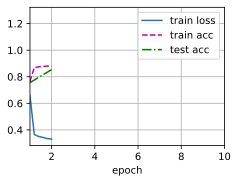

In [65]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())